# Forecasting Net Prophet

You’re a growth analyst at [MercadoLibre](http://investor.mercadolibre.com/about-us). With over 200 million users, MercadoLibre is the most popular e-commerce site in Latin America. You've been tasked with analyzing the company's financial and user data in clever ways to make the company grow. So, you want to find out if the ability to predict search traffic can translate into the ability to successfully trade the stock.

The instructions for this Challenge are divided into four steps, as follows:

* Step 1: Find unusual patterns in hourly Google search traffic

* Step 2: Mine the search traffic data for seasonality

* Step 3: Relate the search traffic to stock price patterns

* Step 4: Create a time series model with Prophet

The following subsections detail these steps.

## Install and import the required libraries and dependencies

In [9]:
# Install the required libraries
!pip install prophet

In [10]:
# Import the required libraries and dependencies
import pandas as pd
from prophet import Prophet
from prophet.plot import plot
from prophet.plot import plot_components
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

The data science manager asks if the Google search traffic for the company links to any financial events at the company. Or, does the search traffic data just present random noise? To answer this question, pick out any unusual patterns in the Google search data for the company, and connect them to the corporate financial events.

To do so, complete the following steps:

1. Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

2. Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?


#### Step 1: Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

In [28]:
# Store the data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.

df_mercado_trends = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/google_hourly_search_trends.csv",
    index_col='Date',
    parse_dates=True ,
    date_format='%Y-%m-%d %H:%M:%S'
).dropna()

# Review the first and last five rows of the DataFrame
display(df_mercado_trends.head())
display(df_mercado_trends.tail())

/var/folders/h7/_b_kcq9965x9k735jh6r_mb80000gn/T/ipykernel_22631/4208627995.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_mercado_trends = pd.read_csv(


,Search Trends
Date,
2016-06-01 00:00:00,97
2016-06-01 01:00:00,92
2016-06-01 02:00:00,76
2016-06-01 03:00:00,60
2016-06-01 04:00:00,38


,Search Trends
Date,
2020-09-07 20:00:00,71
2020-09-07 21:00:00,83
2020-09-07 22:00:00,96
2020-09-07 23:00:00,97
2020-09-08 00:00:00,96


In [29]:
# Review the data types of the DataFrame using the info function
df_mercado_trends.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37106 entries, 2016-06-01 00:00:00 to 2020-09-08 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  37106 non-null  int64
dtypes: int64(1)
memory usage: 579.8 KB


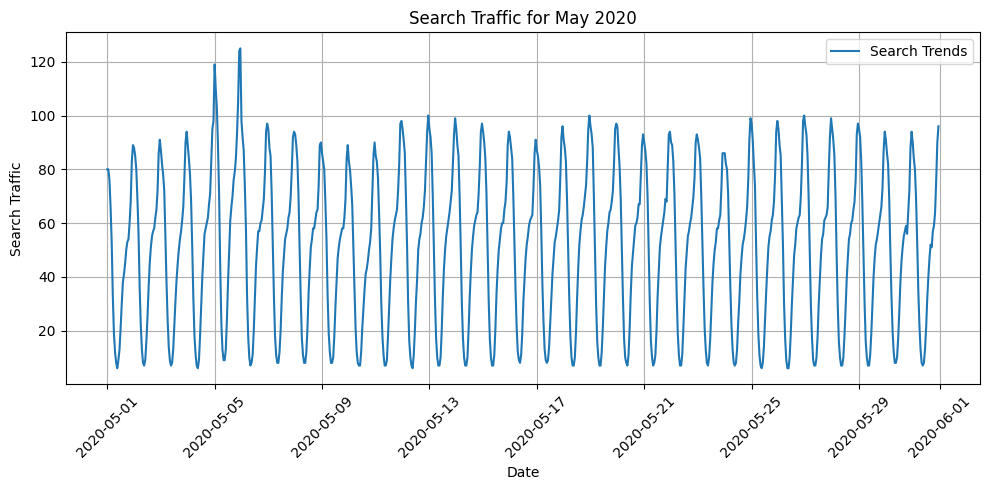

In [30]:
# Slice the DataFrame to just the month of May 2020
may_2020 = df_mercado_trends.loc['2020-05']

# Plot to visualize the data for May 2020
plt.figure(figsize=(10, 5))
plt.plot(may_2020.index, may_2020['Search Trends'], label='Search Trends')
plt.title('Search Traffic for May 2020')
plt.xlabel('Date')
plt.ylabel('Search Traffic')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Step 2: Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?

In [36]:
# Calculate the sum of the total search traffic for May 2020 and show the results
traffic_may_2020 = may_2020['Search Trends'].sum()

# View the traffic_may_2020 value
pd.Series(traffic_may_2020, index=["Search Trends"])

Search Trends    38181
dtype: int64

In [35]:
# Calculate the monthly median search traffic across all months & show results
# Group the DataFrame by index year and then index month, chain the sum and then the median functions
monthly_traffic_sum = df_mercado_trends['Search Trends'].resample('ME').sum()
median_monthly_traffic = monthly_traffic_sum.median()

# View the median_monthly_traffic value
pd.Series(median_monthly_traffic, index=["Search Trends"])

Search Trends    35172.5
dtype: float64

In [34]:
# Compare the seach traffic for the month of May 2020 to the overall monthly median value of traffic
pd.Series((traffic_may_2020/median_monthly_traffic), index=["Search Trends"])

Search Trends    1.085536
dtype: float64

##### Answer the following question:

**Question:** Did the Google search traffic increase during the month that MercadoLibre released its financial results?

**Answer:** Yes, Google search traffic increased during the month when MercadoLibre released its financial results.

In May, the search traffic was 38,181, which is higher than the median monthly traffic of 35,172.5 for the year. This represents an approximate 8.55% increase in search traffic compared to the median of other months.

Given this increase, it is reasonable to conclude that the Google search traffic for MercadoLibre rose during the month of the financial release, likely due to heightened public interest and investor activity surrounding these announcements.

## Step 2: Mine the Search Traffic Data for Seasonality

Marketing realizes that they can use the hourly search data, too. If they can track and predict interest in the company and its platform for any time of day, they can focus their marketing efforts around the times that have the most traffic. This will get a greater return on investment (ROI) from their marketing budget.

To that end, you want to mine the search traffic data for predictable seasonal patterns of interest in the company. To do so, complete the following steps:

1. Group the hourly search data to plot the average traffic by the hour of day. Does the search traffic peak at a particular time of day or is it relatively consistent?

2. Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday). Does the search traffic get busiest on any particular day of the week?

3. Group the hourly search data to plot the average traffic by the week of the year. Does the search traffic tend to increase during the winter holiday period (weeks 40 through 52)?


#### Step 1: Group the hourly search data to plot the average traffic by the hour of the day.

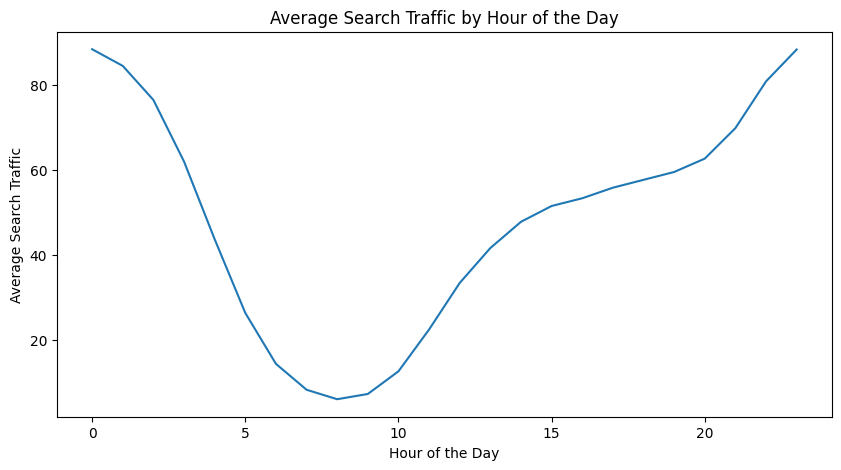

In [43]:
# Group the hourly search data to plot the average traffic by the hour of day, using `df.index.hour` to show the results
average_traffic_by_hour = df_mercado_trends.groupby(df_mercado_trends.index.hour)['Search Trends'].mean()

# Plot the average traffic by hour of the day and display the results
plt.figure(figsize=(10, 5))
average_traffic_by_hour.plot()
plt.title('Average Search Traffic by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Search Traffic')
plt.show()

#### Step 2: Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday).

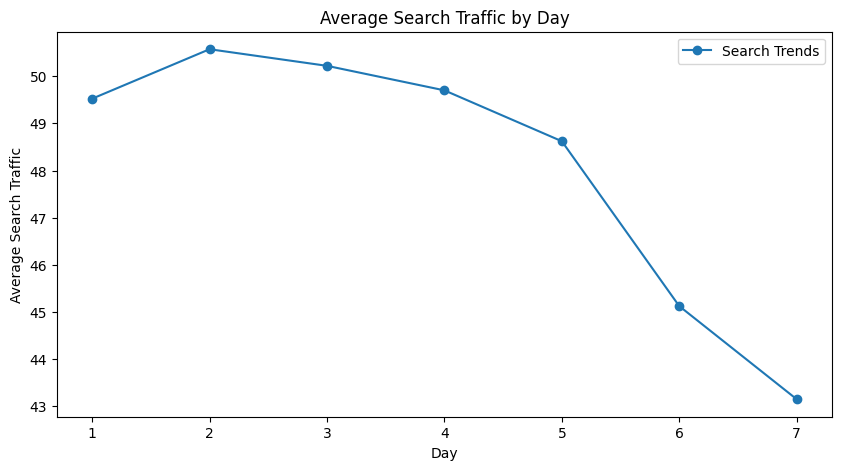

In [44]:
# Group the hourly search data to plot the average traffic by the day of week
# Extract ISO weekday number and store it in a new column 'ISO Weekday'
df_mercado_trends['ISO Weekday'] = df_mercado_trends.index.isocalendar().day

# Group by 'ISO Weekday' and calculate the average search traffic for each day
average_traffic_by_iso_weekday = df_mercado_trends.groupby('ISO Weekday')['Search Trends'].mean()

# Plotting the average traffic by ISO weekday using numbers for days
plt.figure(figsize=(10, 5))
average_traffic_by_iso_weekday.plot(label='Search Trends', marker='o')  
plt.title('Average Search Traffic by Day')
plt.xlabel('Day')
plt.ylabel('Average Search Traffic')
plt.xticks(ticks=range(1, 8))  # Corrected x-ticks to start from 1 to 7
plt.legend()
plt.show()


#### Step 3: Group the hourly search data to plot the average traffic by the week of the year.

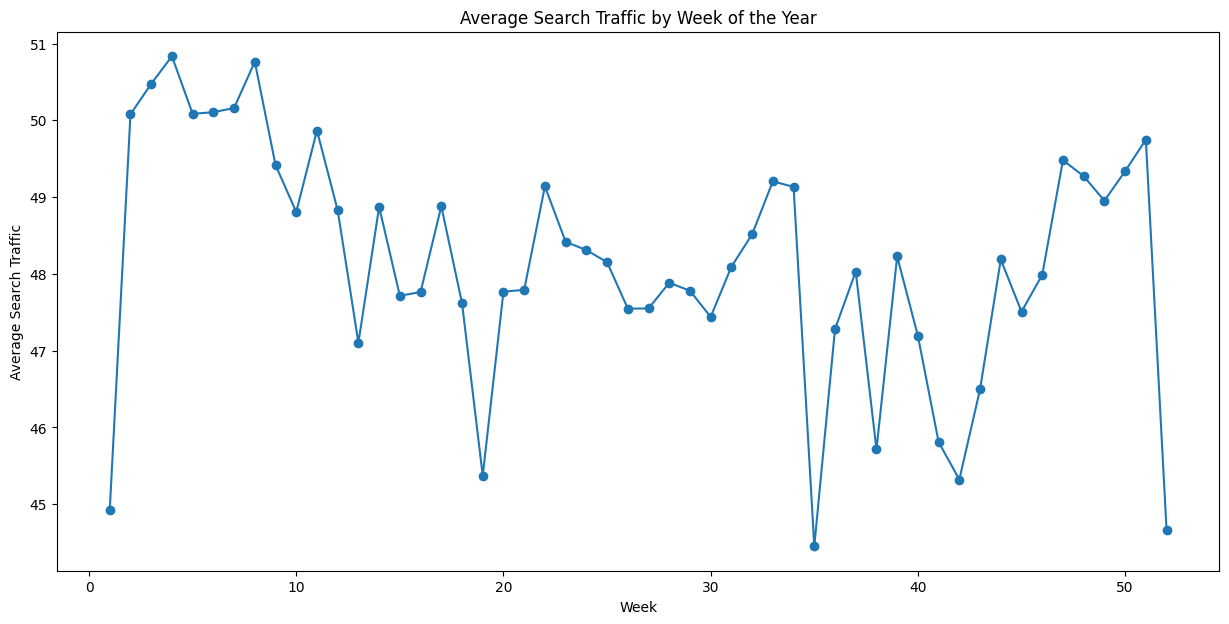

In [42]:
# Group the hourly search data to plot the average traffic by the week of the year using `df.index.isocalendar().week` to display the results.

df_mercado_trends['ISO Week'] = df_mercado_trends.index.isocalendar().week

# Group by 'ISO Week' & calculate the average search traffic for each week
average_traffic_by_iso_week = df_mercado_trends.groupby('ISO Week')['Search Trends'].mean()

# Plotting the average traffic by ISO week of the year
plt.figure(figsize=(15, 7))
average_traffic_by_iso_week.plot(marker='o', linestyle='-')  
plt.title('Average Search Traffic by Week of the Year')
plt.xlabel('Week')
plt.ylabel('Average Search Traffic')

plt.show()

##### Answer the following question:

# Question: Are there any time based trends that you can see in the data?

#Answer:
    
**Hourly Trends (First Graph)**
There is a distinct daily pattern in search traffic. Traffic is at its lowest in the early morning hours, begins to rise around 5 AM, and peaks in the late evening around 9 PM. This indicates that user activity gradually increases throughout the day, reaching its highest point in the evening. The pattern shows a significant drop in activity during typical sleeping hours, followed by a steady increase as the day progresses.

**Day of the Week Trends (Second Graph)**
Search traffic tends to be higher at the beginning of the week, with Monday through Wednesday showing the highest average traffic. There is a noticeable decline as the week progresses, with the lowest traffic observed on Sunday. This could suggest that online activity or interest decreases towards the weekend, possibly due to changes in routine or increased offline activities.

**Weekly Trends Over the Year (Third Graph)**
The graph reveals fluctuating search traffic throughout the year, with several peaks and troughs. This variability suggests that certain weeks may coincide with specific events or seasonal changes that influence search behavior. Notable dips and rises could correlate with holidays, major events, or seasonal trends that affect search engine usage. For example, lower traffic in certain weeks might coincide with major holidays when people are less likely to be online. Additionally, traffic peaks likely coincide with the publication of Mercado's financial disclosures. The highest peaks appear towards the end of the year, which might be related to holiday shopping or activities.

**Conclusions**

Hourly Analysis: People tend to use Google more in the evening hours, likely when they are free from daytime work or school activities.

Weekly Analysis: Search traffic is highest at the start of the workweek and tapers off towards the weekend, suggesting varying engagement levels based on the day of the week.

Annual Analysis: There are periodic fluctuations in search traffic throughout the year, likely driven by cultural, social, or economic events. However, the data is too noisy to draw specific conclusions.

## Step 3: Relate the Search Traffic to Stock Price Patterns

You mention your work on the search traffic data during a meeting with people in the finance group at the company. They want to know if any relationship between the search data and the company stock price exists, and they ask if you can investigate.

To do so, complete the following steps:

1. Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

2. Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

3. Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

    * “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

    * “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis

4. Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?


#### Step 1: Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

In [47]:
# Upload the "mercado_stock_price.csv" file into Colab, then store it in a Pandas DataFrame
# Set the "date" column as the Datetime Index.
df_mercado_stock = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True
).dropna()

# View the first and last five rows of the DataFrame
display(df_mercado_stock.head())
display(df_mercado_stock.tail())

,close
date,
2015-01-02 09:00:00,127.67
2015-01-02 10:00:00,125.44
2015-01-02 11:00:00,125.57
2015-01-02 12:00:00,125.40
2015-01-02 13:00:00,125.17


,close
date,
2020-07-31 11:00:00,1105.780
2020-07-31 12:00:00,1087.925
2020-07-31 13:00:00,1095.800
2020-07-31 14:00:00,1110.650
2020-07-31 15:00:00,1122.510


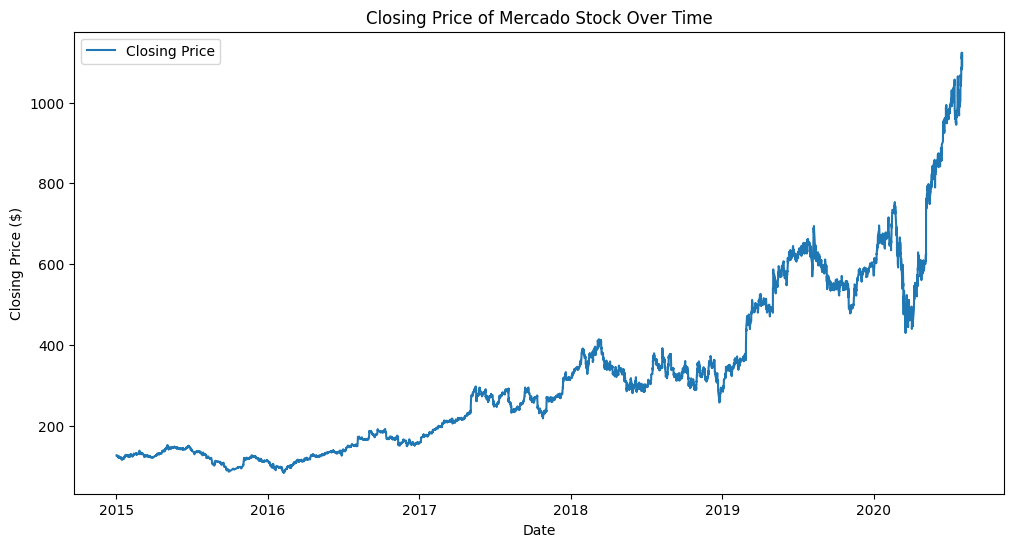

In [48]:
# Visualize the closing price of the df_mercado_stock DataFrame & display it below in a chart
plt.figure(figsize=(12, 6))
plt.plot(df_mercado_stock['close'], label='Closing Price')
plt.title('Closing Price of Mercado Stock Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.show()

In [49]:
# Concatenate the df_mercado_stock DataFrame with the df_mercado_trends DataFrame
# Concatenate the DataFrame by columns (axis=1) & drop and rows with only one column of data


# Concatenate the DataFrames along columns
combined_df = pd.concat([df_mercado_stock, df_mercado_trends], axis=1, join='inner')

combined_df.drop(columns=['ISO Weekday', 'ISO Week'], inplace=True)

# View the first and last five rows of the DataFrame
display(combined_df.head())
display(combined_df.tail())

,close,Search Trends
2016-06-01 09:00:00,135.16,6
2016-06-01 10:00:00,136.63,12
2016-06-01 11:00:00,136.56,22
2016-06-01 12:00:00,136.42,33
2016-06-01 13:00:00,136.10,40


,close,Search Trends
2020-07-31 11:00:00,1105.780,20
2020-07-31 12:00:00,1087.925,32
2020-07-31 13:00:00,1095.800,41
2020-07-31 14:00:00,1110.650,47
2020-07-31 15:00:00,1122.510,53


#### Step 2: Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

In [51]:
# For the combined dataframe, slice to just the 1st half of 2020 (data from 2020-01 through 2020-06)
first_half_2020 = combined_df['2020-01':'2020-06']

# View the first & last 5 rows of first_half_2020 DataFrame
display(first_half_2020.head())
display(first_half_2020.tail())

,close,Search Trends
2020-01-02 09:00:00,601.085,9
2020-01-02 10:00:00,601.290,14
2020-01-02 11:00:00,615.410,25
2020-01-02 12:00:00,611.400,37
2020-01-02 13:00:00,611.830,50


,close,Search Trends
2020-06-30 11:00:00,976.17,17
2020-06-30 12:00:00,977.50,27
2020-06-30 13:00:00,973.23,37
2020-06-30 14:00:00,976.50,45
2020-06-30 15:00:00,984.93,51


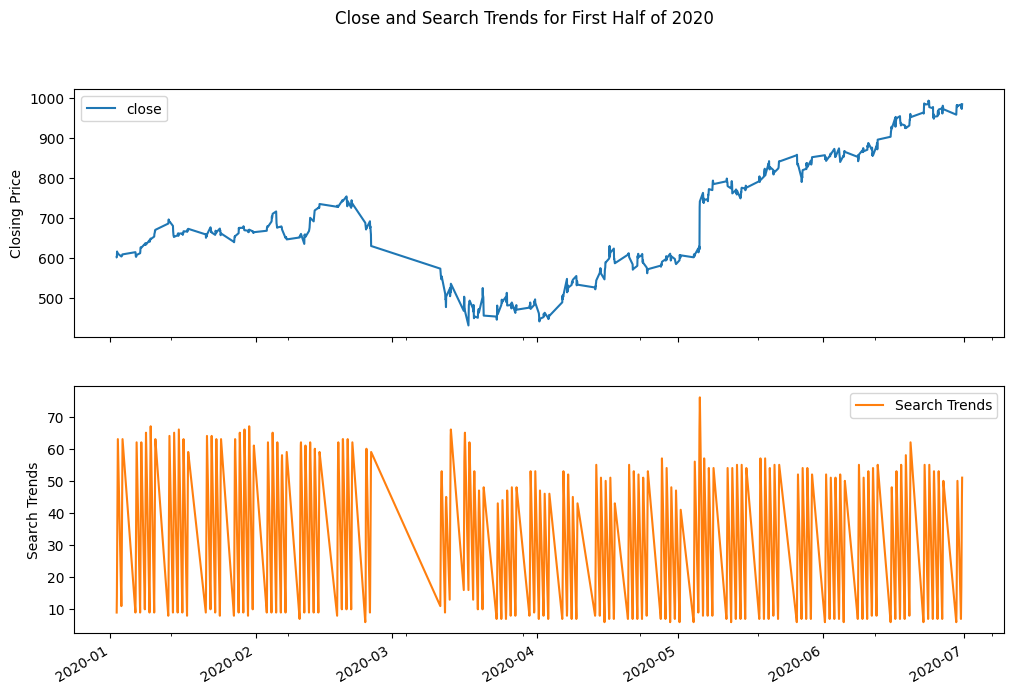

In [52]:
# Visualize the close and Search Trends data
# Plot each column on a separate axis using the following syntax
# `plot(subplots=True)`

ax = first_half_2020[['close', 'Search Trends']].plot(subplots=True, figsize=(12, 8), title='Close and Search Trends for First Half of 2020')

# Labeling axes
ax[0].set_ylabel('Closing Price')
ax[1].set_ylabel('Search Trends')

# Displaying the plot
plt.show()

##### Answer the following question:

**Question:** Do both time series indicate a common trend that’s consistent with this narrative?

**Answer:**

**Closing Stock Price (Top Chart)**
The closing price starts off relatively stable but experiences a significant drop towards the end of March, aligning with the initial impact of the COVID-19 pandemic on global financial markets.
After this drop, there is a strong recovery and a steady rise in stock prices through June, reflecting recovering investor confidence and possibly increased business due to a shift in consumer behavior favoring online shopping and e-commerce as pandemic-related restrictions intensified.

**Search Trends (Bottom Chart)**
The search trends show high volatility, with periodic spikes that could indicate increased public interest or activity related to MercadoLibre.
From March onwards, there is a noticeable increase in search activity peaks, suggesting growing public interest or heightened consumer engagement with the platform, likely due to the increased reliance on e-commerce during lockdown periods.

**Analysis of Trends with Narrative**
- **Common Trend Analysis:** Both the closing price and search trends exhibit significant activity and changes during the first half of 2020. After an initial downturn in March, both metrics demonstrate recovery and growth, indicating that MercadoLibre likely benefited from the surge in e-commerce activity as traditional retail faced disruptions due to the pandemic.

- **Consistency with 2020 E-commerce Narrative:** The observed data is consistent with the broader 2020 narrative where e-commerce platforms saw new customer growth and revenue increases. The recovery in the stock price and increased search trends post-March align with this narrative, suggesting that as the pandemic caused a shift in shopping behavior, platforms like MercadoLibre captured new market opportunities and interest.

**Conclusion**
Both time series data—closing stock price and search trends—support the notion that despite initial shocks, MercadoLibre, like many e-commerce entities, found significant growth opportunities during the pandemic. The impact of the initial shock and the subsequent recovery in both metrics indicate a shift in consumer behavior and market dynamics favoring online commerce, which aligns well with the broader economic impacts observed during that period.

#### Step 3: Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

* “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

* “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis


In [56]:
# Create a new column in the mercado_stock_trends_df DataFrame called Lagged Search Trends
# This column shifts the Search Trends information by one hour
combined_df['Lagged Search Trends'] = combined_df['Search Trends'].shift(1)

In [57]:
# Create a new column in the mercado_stock_trends_df DataFrame called Stock Volatility
# This column calculates the standard deviation of the closing stock price return data over a 4 period rolling window
combined_df['Returns'] = combined_df['close'].pct_change()
combined_df['Stock Volatility'] = combined_df['Returns'].rolling(window=4).std()

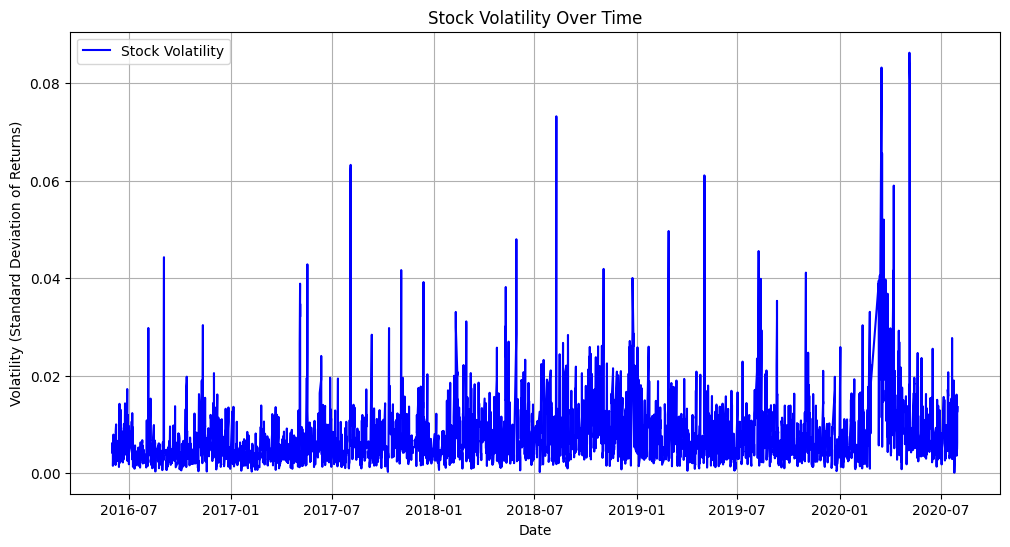

In [55]:
# Visualize the stock volatility
plt.figure(figsize=(12, 6))
plt.plot(combined_df['Stock Volatility'], label='Stock Volatility', color='blue')
plt.title('Stock Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility (Standard Deviation of Returns)')
plt.legend()
plt.grid(True)
plt.show()

**Solution Note:** Note how volatility spiked, and tended to stay high, during the first half of 2020. This is a common characteristic of volatility in stock returns worldwide: high volatility days tend to be followed by yet more high volatility days. When it rains, it pours.

In [58]:
# Create a new column in the mercado_stock_trends_df DataFrame called Hourly Stock Return
# This column calculates hourly return percentage of the closing price
combined_df['Hourly Stock Return'] = combined_df['close'].pct_change()

In [59]:
# View the first and last five rows of the mercado_stock_trends_df DataFrame
display(combined_df.head())
display(combined_df.tail())

,close,Search Trends,Lagged Search Trends,Returns,Stock Volatility,Hourly Stock Return
2016-06-01 09:00:00,135.16,6,NaN,NaN,NaN,NaN
2016-06-01 10:00:00,136.63,12,6.0,0.010876,NaN,0.010876
2016-06-01 11:00:00,136.56,22,12.0,-0.000512,NaN,-0.000512
2016-06-01 12:00:00,136.42,33,22.0,-0.001025,NaN,-0.001025
2016-06-01 13:00:00,136.10,40,33.0,-0.002346,0.006134,-0.002346


,close,Search Trends,Lagged Search Trends,Returns,Stock Volatility,Hourly Stock Return
2020-07-31 11:00:00,1105.780,20,11.0,0.006380,0.012837,0.006380
2020-07-31 12:00:00,1087.925,32,20.0,-0.016147,0.013549,-0.016147
2020-07-31 13:00:00,1095.800,41,32.0,0.007239,0.013295,0.007239
2020-07-31 14:00:00,1110.650,47,41.0,0.013552,0.013001,0.013552
2020-07-31 15:00:00,1122.510,53,47.0,0.010678,0.013566,0.010678


#### Step 4: Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

In [60]:
# Construct correlation table of Stock Volatility, Lagged Search Trends & Hourly Stock Return
combined_df[['Stock Volatility', 'Lagged Search Trends', 'Hourly Stock Return']].corr()

,Stock Volatility,Lagged Search Trends,Hourly Stock Return
Stock Volatility,1.000000,-0.148938,0.061424
Lagged Search Trends,-0.148938,1.000000,0.017929
Hourly Stock Return,0.061424,0.017929,1.000000


##### Answer the following question:


**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

**Answer:**

The data does not support a strong or predictable relationship between lagged search traffic and either stock volatility or hourly stock returns based on the provided correlation coefficients. This lack of a strong correlation suggests that lagged search traffic is not a reliable predictor for changes in stock volatility or returns in this dataset. This might be due to several factors, including the nature of the data, the specific timeframe, or external influences not captured by search trends alone.

- **Lagged Search Trends and Stock Volatility:** The correlation coefficient between "Lagged Search Trends" and "Stock Volatility" is -0.148938. This indicates a weak, negative relationship. As the lagged search trends increase, there is a slight tendency for stock volatility to decrease, although the relationship is not very strong.

- **Lagged Search Trends and Hourly Stock Return:** The correlation between "Lagged Search Trends" and "Hourly Stock Return" is 0.017929. This value is very close to zero, suggesting that there is virtually no linear relationship between lagged search trends and the hourly stock returns.

**Interpretation**

- **Stock Volatility:** The negative correlation, though weak, suggests that periods with higher search activity might slightly precede more stable times for the stock, or conversely, less search activity might precede more volatile times. However, the strength of this correlation is so weak that it might not be practically significant.
  
- **Hourly Stock Return:** The near-zero correlation implies that changes in search trends from one hour to the next do not consistently or significantly affect the stock's return in the subsequent hour.

## Step 4: Create a Time Series Model with Prophet

Now, you need to produce a time series model that analyzes and forecasts patterns in the hourly search data. To do so, complete the following steps:

1. Set up the Google search data for a Prophet forecasting model.

2. After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

3. Plot the individual time series components of the model to answer the following questions:

    * What time of day exhibits the greatest popularity?

    * Which day of the week gets the most search traffic?

    * What's the lowest point for search traffic in the calendar year?


#### Step 1: Set up the Google search data for a Prophet forecasting model.

In [61]:
# Use the df_mercado_trends DataFrame & reset the index so the date information is no longer the index
df_mercado_trends.reset_index(inplace=True)

# Label the columns ds and y so that the syntax is recognized by Prophet
df_mercado_trends.rename(columns={'Date': 'ds', 'Search Trends': 'y'}, inplace=True)

# Drop an NaN values from the prophet_df DataFrame
df_mercado_trends.dropna(inplace=True)

# Drop the 'ISO Weekday' and 'ISO Week' columns from the DataFrame
df_mercado_trends.drop(columns=['ISO Weekday', 'ISO Week'], inplace=True)

# Rename DataFrame
mercado_prophet_df = df_mercado_trends

# View the first & last 5 rows of the mercado_prophet_df DataFrame
display(mercado_prophet_df.head())
display(mercado_prophet_df.tail())

,ds,y
0,2016-06-01 00:00:00,97
1,2016-06-01 01:00:00,92
2,2016-06-01 02:00:00,76
3,2016-06-01 03:00:00,60
4,2016-06-01 04:00:00,38


,ds,y
37101,2020-09-07 20:00:00,71
37102,2020-09-07 21:00:00,83
37103,2020-09-07 22:00:00,96
37104,2020-09-07 23:00:00,97
37105,2020-09-08 00:00:00,96


In [62]:
# Call the Prophet function, store as an object
model = Prophet()
model

In [63]:
# Fit the time-series model.
model.fit(mercado_prophet_df)

22:41:10 - cmdstanpy - INFO - Chain [1] start processing
22:41:19 - cmdstanpy - INFO - Chain [1] done processing


In [66]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 2000 hours (approx 80 days)
future_dates = model.make_future_dataframe(periods=2000, freq='h')

# Display the last 5 rows of the future_mercado_trends DataFrame
future_dates.tail()

,ds
39101,2020-11-30 04:00:00
39102,2020-11-30 05:00:00
39103,2020-11-30 06:00:00
39104,2020-11-30 07:00:00
39105,2020-11-30 08:00:00


In [67]:
# Make the predictions for the trend data using the future_mercado_trends DataFrame
forecast = model.predict(future_dates)

# Display the first 5 rows of the forecast_mercado_trends DataFrame
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-06-01 00:00:00,44.129250,81.220563,97.968446,44.129250,44.129250,45.429305,45.429305,45.429305,41.452726,...,1.860133,1.860133,1.860133,2.116445,2.116445,2.116445,0.0,0.0,0.0,89.558555
1,2016-06-01 01:00:00,44.130313,77.408511,95.347533,44.130313,44.130313,41.875073,41.875073,41.875073,37.943506,...,1.810049,1.810049,1.810049,2.121518,2.121518,2.121518,0.0,0.0,0.0,86.005386
2,2016-06-01 02:00:00,44.131375,66.887590,84.406266,44.131375,44.131375,31.551566,31.551566,31.551566,27.656533,...,1.768474,1.768474,1.768474,2.126559,2.126559,2.126559,0.0,0.0,0.0,75.682942
3,2016-06-01 03:00:00,44.132438,51.782561,69.333584,44.132438,44.132438,16.284352,16.284352,16.284352,12.417280,...,1.735502,1.735502,1.735502,2.131569,2.131569,2.131569,0.0,0.0,0.0,60.416789
4,2016-06-01 04:00:00,44.133500,34.625942,52.169364,44.133500,44.133500,-0.830504,-0.830504,-0.830504,-4.678139,...,1.711088,1.711088,1.711088,2.136547,2.136547,2.136547,0.0,0.0,0.0,43.302997


#### Step 2: After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

/Applications/anaconda3/envs/new_env/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Applications/anaconda3/envs/new_env/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


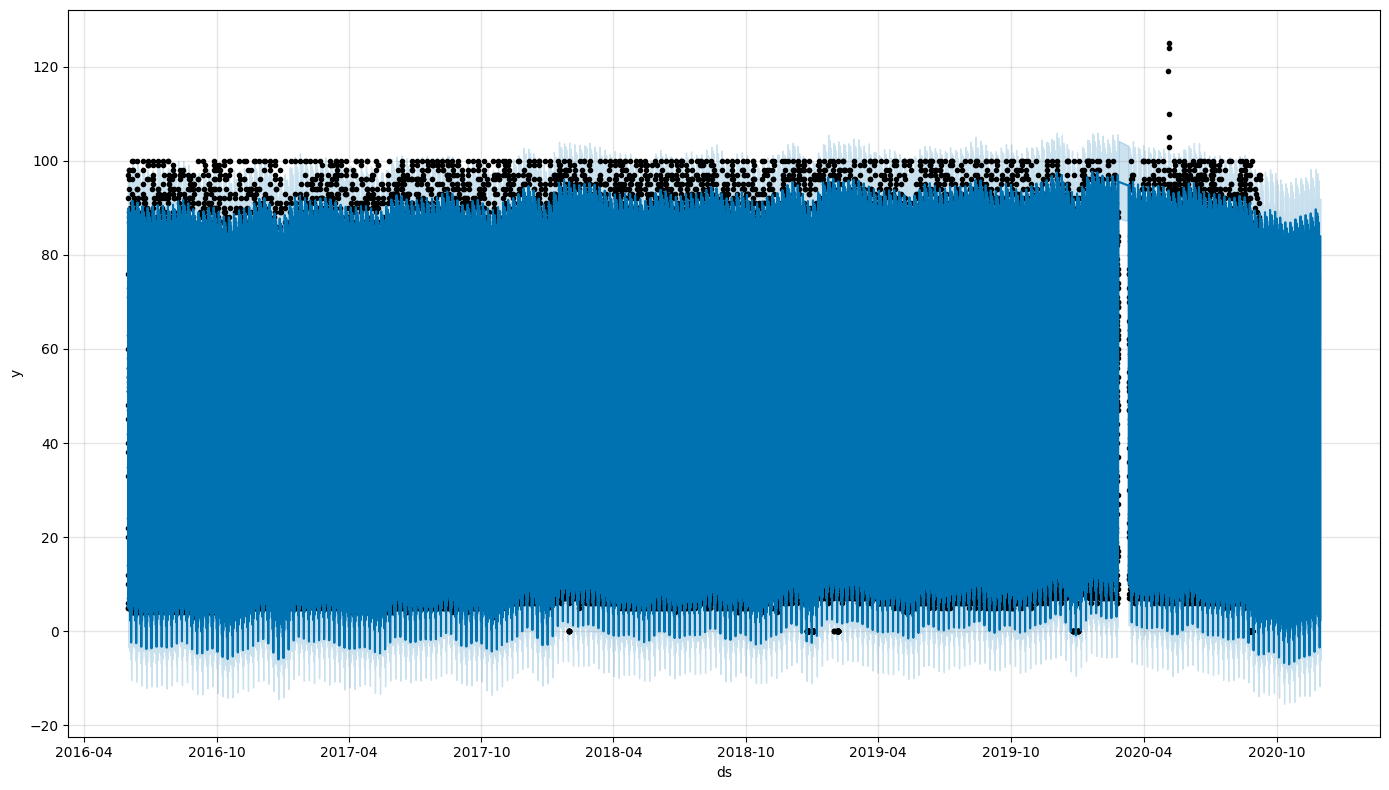

In [68]:
# Plot the Prophet predictions for the Mercado trends data
fig = plot(model, forecast, figsize=(14, 8))
plt.show()

##### Answer the following question:

**Question:**  How's the near-term forecast for the popularity of MercadoLibre?

**Answer:**

- **Current Trend:** The forecast immediately beyond the last historical data point starts high but shows a slight decreasing trend. This might indicate a stabilization or slight decline in the search trends for MercadoLibre following this peak.
  
- **Uncertainty:**  The uncertainty interval (shaded area) widens as the forecast extends, indicating increasing uncertainty in the prediction as we move further from the last known data point. This is typical in time series forecasting, where predictions become less confident as they project further into the future.
  
- **Overall:** Despite the short-term decline, the forecast suggests that MercadoLibre remains popular, maintaining higher levels of search activity compared to historical data.

This forecast indicates sustained interest in MercadoLibre with normal fluctuations expected in the short term.

#### Step 3: Plot the individual time series components of the model to answer the following questions:

* What time of day exhibits the greatest popularity?

* Which day of the week gets the most search traffic?

* What's the lowest point for search traffic in the calendar year?


In [69]:
# Set the index in the forecast_mercado_trends DataFrame to the ds datetime column
forecast.set_index('ds', inplace=True)

# View the only the yhat,yhat_lower and yhat_upper columns from the DataFrame
forecast[['yhat', 'yhat_lower', 'yhat_upper']]

,yhat,yhat_lower,yhat_upper
ds,,,
2016-06-01 00:00:00,89.558555,81.220563,97.968446
2016-06-01 01:00:00,86.005386,77.408511,95.347533
2016-06-01 02:00:00,75.682942,66.887590,84.406266
2016-06-01 03:00:00,60.416789,51.782561,69.333584
2016-06-01 04:00:00,43.302997,34.625942,52.169364
...,...,...,...
2020-11-30 04:00:00,39.283272,30.675352,47.655065
2020-11-30 05:00:00,23.812065,16.320955,32.507417
2020-11-30 06:00:00,11.846318,3.515021,20.921322


Solutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represents the worst and best case prediction (based on what are known as 95% confidence intervals).

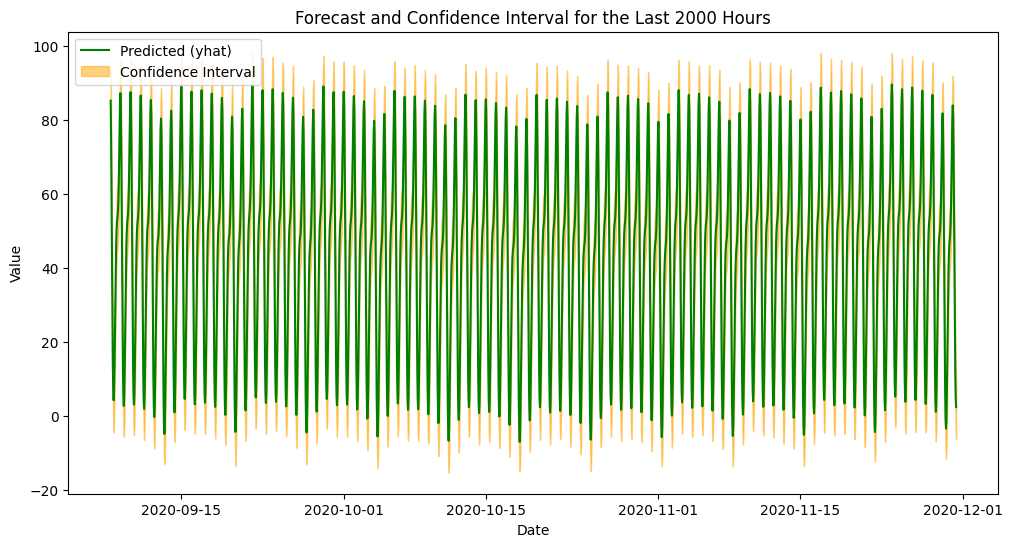

In [70]:
# From the forecast_mercado_trends DataFrame, plot the data to visualize
#  the yhat, yhat_lower, and yhat_upper columns over the last 2000 hours

# Slice the last 2000 hours of data
last_2000_hours = forecast[-2000:]

# Plotting the forecast and its confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(last_2000_hours.index, last_2000_hours['yhat'], label='Predicted (yhat)', color='green')  # Changed to green
plt.fill_between(last_2000_hours.index, last_2000_hours['yhat_lower'], last_2000_hours['yhat_upper'], color='orange', alpha=0.5, label='Confidence Interval') 
plt.title('Forecast and Confidence Interval for the Last 2000 Hours')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

/Applications/anaconda3/envs/new_env/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Applications/anaconda3/envs/new_env/lib/python3.11/site-packages/prophet/plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/Applications/anaconda3/envs/new_env/lib/python3.11/site-packages/prophet/plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python d

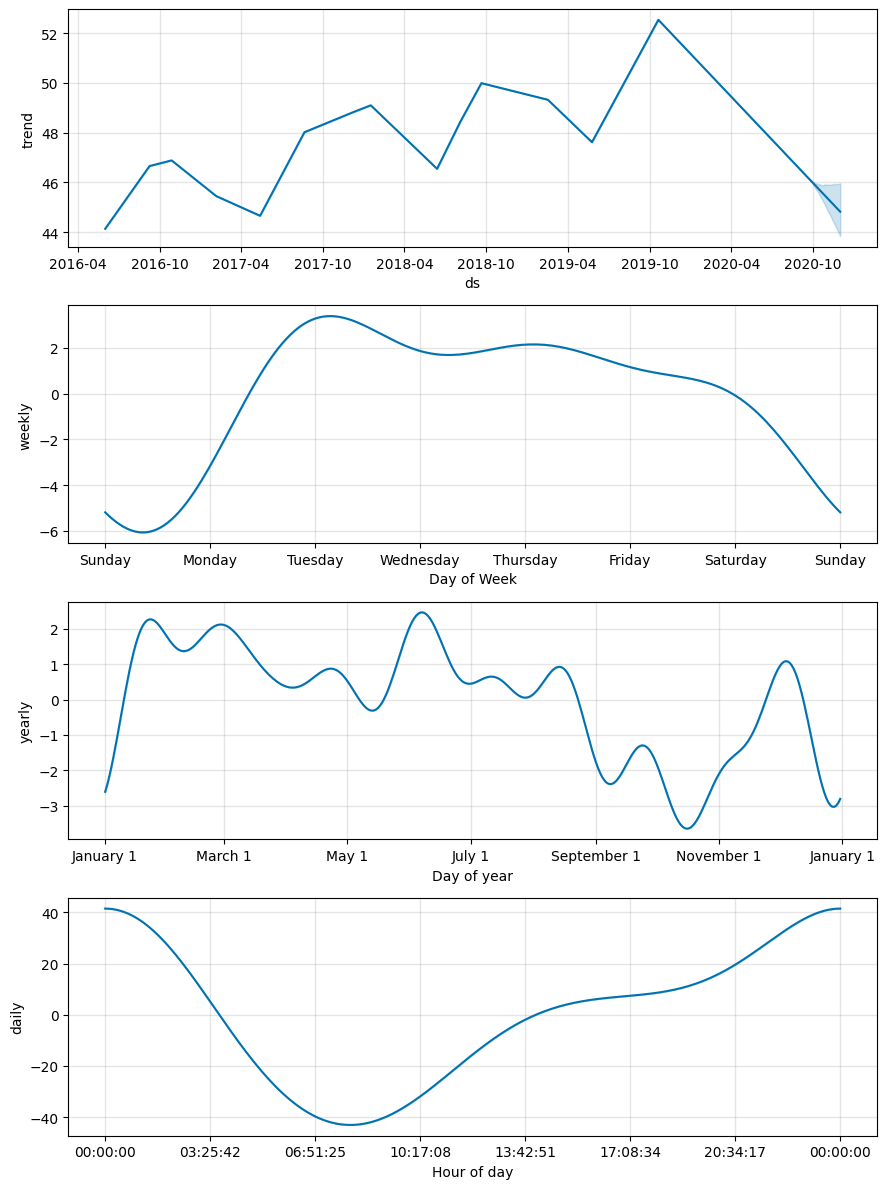

In [71]:
# Reset the index in the forecast_mercado_trends DataFrame
if 'ds' not in forecast.columns:
    # If 'ds' is not in columns, it might be the index or missing
    forecast.reset_index(inplace=True)
    # Ensure 'ds' is set as a column
    if 'ds' not in forecast.columns:
        forecast['ds'] = forecast.index  # Assuming index has date-time info, this is a fallback

# Convert 'ds' to datetime if it is not already
if not pd.api.types.is_datetime64_any_dtype(forecast['ds']):
    forecast['ds'] = pd.to_datetime(forecast['ds'])

# Use the plot_components function to visualize the forecast results
fig_components = plot_components(model, forecast)
plt.show()


##### Answer the following questions:

**Question:** What time of day exhibits the greatest popularity?

**Answer:**
The time of day that exhibits the greatest popularity is around 8:30 PM (20:30) and midnight (00:00). This is indicated by the peaks in the daily component of the plot.

**Question:** Which day of week gets the most search traffic?
   
**Answer:**
According to the weekly component of the plot, Tuesday receives the most search traffic, as it shows the peak before traffic gradually declines through the rest of the week.

**Question:** What's the lowest point for search traffic in the calendar year?

**Answer:**
The lowest point for search traffic in the calendar year occurs around the beginning of January, as indicated by the deep trough in the yearly component of the plot. This likely corresponds to the period just after the New Year holiday when activity may temporarily dip.